# オッズデータとラベルデータ（人気順，払い戻し金）の結合，前処理

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("/Users/k17099kk/bigdata/keiba/"))

# Any results you write to the current directory are saved as output.

['rowOdds.csv', 'modified_harai.csv']


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import lightgbm as lgb
import seaborn as sns
import warnings
import time

/Users/k17099kk/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [3]:
Odds = pd.read_csv("/Users/k17099kk/bigdata/keiba/rowOdds.csv")
label = pd.read_csv("/Users/k17099kk/bigdata/keiba/modified_harai.csv")

In [4]:
Odds.head(5)

,rank_1,rank_2,rank_3,rank_4,rank_5,rank_6,rank_7,rank_8,rank_9,rank_10,...,rank_291,rank_292,rank_293,rank_294,rank_295,rank_296,rank_297,rank_298,rank_299,rank_300
0,145,148,185,205,222,252,258,259,262,319,...,36854,36854,37402,37588,38547,38744,38744,39146,41285,41512
1,105,115,120,160,191,198,244,274,287,292,...,46651,46964,46964,46964,47603,47603,48594,48594,48934,49628
2,97,127,131,139,142,215,239,364,368,411,...,0,0,0,0,0,0,0,0,0,0
3,117,120,121,143,211,286,295,300,305,305,...,0,0,0,0,0,0,0,0,0,0
4,97,131,142,188,216,224,237,327,330,336,...,55168,55491,56482,56820,57163,57509,58938,58938,60057,60057


In [5]:
label.head(5)

,harai,rank
0,7070,22
1,1600,4
2,4160,11
3,3050,9
4,11910,37


In [6]:
Odds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11970 entries, 0 to 11969
Columns: 300 entries, rank_1 to rank_300
dtypes: int64(300)
memory usage: 27.4 MB


In [7]:
label.info(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11970 entries, 0 to 11969
Data columns (total 2 columns):
harai    11970 non-null int64
rank     11970 non-null int64
dtypes: int64(2)
memory usage: 187.1 KB


In [8]:
Odds.shape

(11970, 300)

In [9]:
Odds.describe()

,rank_1,rank_2,rank_3,rank_4,rank_5,rank_6,rank_7,rank_8,rank_9,rank_10,...,rank_291,rank_292,rank_293,rank_294,rank_295,rank_296,rank_297,rank_298,rank_299,rank_300
count,11970.000000,11970.000000,11970.000000,11970.000000,11970.000000,11970.000000,11970.000000,11970.000000,11970.000000,11970.000000,...,11970.00000,11970.000000,11970.000000,11970.000000,11970.000000,11970.000000,11970.000000,11970.000000,11970.000000,11970.000000
mean,122.602506,159.948705,185.850209,217.002089,245.544779,272.832331,300.365915,326.996992,352.461988,378.559231,...,25482.60543,25721.601337,25964.084211,26203.195405,26450.657811,26698.067251,26944.763158,27203.333584,27465.881871,27722.848454
std,62.094277,68.898764,72.714402,75.702663,79.001909,81.116094,82.805111,84.386698,85.986776,87.413612,...,24761.25689,25014.935445,25271.994660,25535.640422,25815.629393,26093.082362,26360.355895,26666.109372,26961.964768,27232.467025
min,14.000000,29.000000,35.000000,59.000000,74.000000,81.000000,123.000000,128.000000,147.000000,160.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,78.000000,112.000000,134.000000,163.000000,190.000000,216.000000,242.000000,268.000000,292.250000,318.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,111.000000,148.000000,174.000000,204.000000,231.000000,259.000000,287.000000,313.000000,340.000000,366.000000,...,22117.00000,22301.000000,22475.000000,22638.500000,22822.500000,22991.000000,23220.500000,23388.000000,23599.500000,23810.500000
75%,154.000000,196.000000,224.000000,256.000000,287.000000,314.750000,343.000000,371.750000,399.000000,425.000000,...,38674.00000,39039.250000,39363.000000,39793.000000,40124.250000,40488.750000,40949.000000,41308.500000,41616.250000,42098.500000
max,625.000000,684.000000,699.000000,729.000000,747.000000,780.000000,796.000000,835.000000,906.000000,947.000000,...,190008.00000,190008.000000,192634.000000,203965.000000,203965.000000,203965.000000,203965.000000,206773.000000,206773.000000,206773.000000


In [10]:
label.describe()

,harai,rank
count,1.197000e+04,11970.000000
mean,2.393353e+04,42.816708
std,9.475960e+04,67.529968
min,1.400000e+02,1.000000
25%,2.172500e+03,5.000000
50%,5.550000e+03,17.000000
75%,1.628000e+04,50.000000
max,5.508830e+06,726.000000


In [11]:
df = pd.DataFrame(data=Odds)
df

,rank_1,rank_2,rank_3,rank_4,rank_5,rank_6,rank_7,rank_8,rank_9,rank_10,...,rank_291,rank_292,rank_293,rank_294,rank_295,rank_296,rank_297,rank_298,rank_299,rank_300
0,145,148,185,205,222,252,258,259,262,319,...,36854,36854,37402,37588,38547,38744,38744,39146,41285,41512
1,105,115,120,160,191,198,244,274,287,292,...,46651,46964,46964,46964,47603,47603,48594,48594,48934,49628
2,97,127,131,139,142,215,239,364,368,411,...,0,0,0,0,0,0,0,0,0,0
3,117,120,121,143,211,286,295,300,305,305,...,0,0,0,0,0,0,0,0,0,0
4,97,131,142,188,216,224,237,327,330,336,...,55168,55491,56482,56820,57163,57509,58938,58938,60057,60057
5,94,108,118,225,250,276,310,326,345,389,...,26605,26681,27148,27148,27227,27468,27796,27796,28047,28740
6,164,226,234,246,294,317,330,335,389,408,...,39409,40362,41024,41708,43711,44096,44096,45294,45707,45917
7,166,179,198,229,248,264,286,291,310,333,...,20806,20806,21056,21092,21165,21202,21386,21499,21921,22199
8,170,179,195,276,335,340,340,361,367,401,...,19756,19965,19988,20202,20226,20274,20347,20769,21052,21157
9,60,60,105,130,144,195,207,270,273,290,...,0,0,0,0,0,0,0,0,0,0


In [12]:
df = df.replace(0, np.nan)

In [13]:
df.describe()

,rank_1,rank_2,rank_3,rank_4,rank_5,rank_6,rank_7,rank_8,rank_9,rank_10,...,rank_291,rank_292,rank_293,rank_294,rank_295,rank_296,rank_297,rank_298,rank_299,rank_300
count,11970.000000,11970.000000,11970.000000,11970.000000,11970.000000,11970.000000,11970.000000,11970.000000,11970.000000,11970.000000,...,8325.000000,8325.000000,8325.000000,8325.000000,8325.000000,8325.000000,8325.000000,8325.000000,8325.000000,8325.000000
mean,122.602506,159.948705,185.850209,217.002089,245.544779,272.832331,300.365915,326.996992,352.461988,378.559231,...,36639.854294,36983.491652,37332.142703,37675.945826,38031.756637,38387.491291,38742.200000,39113.982342,39491.484204,39860.960480
std,62.094277,68.898764,72.714402,75.702663,79.001909,81.116094,82.805111,84.386698,85.986776,87.413612,...,21742.816633,21981.846096,22223.812899,22478.990866,22754.668130,23026.172481,23281.559399,23590.851125,23881.059118,24134.105711
min,14.000000,29.000000,35.000000,59.000000,74.000000,81.000000,123.000000,128.000000,147.000000,160.000000,...,7026.000000,7041.000000,7112.000000,7112.000000,7228.000000,7288.000000,7288.000000,7303.000000,7349.000000,7366.000000
25%,78.000000,112.000000,134.000000,163.000000,190.000000,216.000000,242.000000,268.000000,292.250000,318.000000,...,21013.000000,21203.000000,21351.000000,21502.000000,21722.000000,21899.000000,22079.000000,22244.000000,22400.000000,22596.000000
50%,111.000000,148.000000,174.000000,204.000000,231.000000,259.000000,287.000000,313.000000,340.000000,366.000000,...,31026.000000,31291.000000,31591.000000,31813.000000,32135.000000,32475.000000,32735.000000,32978.000000,33270.000000,33565.000000
75%,154.000000,196.000000,224.000000,256.000000,287.000000,314.750000,343.000000,371.750000,399.000000,425.000000,...,46456.000000,46899.000000,47348.000000,47838.000000,48213.000000,48614.000000,49135.000000,49611.000000,50139.000000,50687.000000
max,625.000000,684.000000,699.000000,729.000000,747.000000,780.000000,796.000000,835.000000,906.000000,947.000000,...,190008.000000,190008.000000,192634.000000,203965.000000,203965.000000,203965.000000,203965.000000,206773.000000,206773.000000,206773.000000


In [14]:
df.isnull().sum()

rank_1         0
rank_2         0
rank_3         0
rank_4         0
rank_5         0
rank_6         0
rank_7         0
rank_8         0
rank_9         0
rank_10        0
rank_11        4
rank_12        4
rank_13        4
rank_14        4
rank_15        4
rank_16        4
rank_17        4
rank_18        4
rank_19        4
rank_20        4
rank_21       25
rank_22       25
rank_23       25
rank_24       25
rank_25       25
rank_26       25
rank_27       25
rank_28       25
rank_29       25
rank_30       25
            ... 
rank_271    2743
rank_272    2743
rank_273    2743
rank_274    2743
rank_275    2743
rank_276    2743
rank_277    2743
rank_278    2743
rank_279    2743
rank_280    2743
rank_281    2743
rank_282    2743
rank_283    2743
rank_284    2743
rank_285    2743
rank_286    2743
rank_287    3645
rank_288    3645
rank_289    3645
rank_290    3645
rank_291    3645
rank_292    3645
rank_293    3645
rank_294    3645
rank_295    3645
rank_296    3645
rank_297    3645
rank_298    36

In [15]:
df.dtypes

rank_1        int64
rank_2        int64
rank_3        int64
rank_4        int64
rank_5        int64
rank_6        int64
rank_7        int64
rank_8        int64
rank_9        int64
rank_10       int64
rank_11     float64
rank_12     float64
rank_13     float64
rank_14     float64
rank_15     float64
rank_16     float64
rank_17     float64
rank_18     float64
rank_19     float64
rank_20     float64
rank_21     float64
rank_22     float64
rank_23     float64
rank_24     float64
rank_25     float64
rank_26     float64
rank_27     float64
rank_28     float64
rank_29     float64
rank_30     float64
             ...   
rank_271    float64
rank_272    float64
rank_273    float64
rank_274    float64
rank_275    float64
rank_276    float64
rank_277    float64
rank_278    float64
rank_279    float64
rank_280    float64
rank_281    float64
rank_282    float64
rank_283    float64
rank_284    float64
rank_285    float64
rank_286    float64
rank_287    float64
rank_288    float64
rank_289    float64


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11970 entries, 0 to 11969
Columns: 300 entries, rank_1 to rank_300
dtypes: float64(290), int64(10)
memory usage: 27.4 MB


In [28]:
dff = pd.concat([label, df], axis=1)
dff.head(5)

,harai,rank,rank_1,rank_2,rank_3,rank_4,rank_5,rank_6,rank_7,rank_8,...,rank_291,rank_292,rank_293,rank_294,rank_295,rank_296,rank_297,rank_298,rank_299,rank_300
0,7070,22,145,148,185,205,222,252,258,259,...,36854.0,36854.0,37402.0,37588.0,38547.0,38744.0,38744.0,39146.0,41285.0,41512.0
1,1600,4,105,115,120,160,191,198,244,274,...,46651.0,46964.0,46964.0,46964.0,47603.0,47603.0,48594.0,48594.0,48934.0,49628.0
2,4160,11,97,127,131,139,142,215,239,364,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3050,9,117,120,121,143,211,286,295,300,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11910,37,97,131,142,188,216,224,237,327,...,55168.0,55491.0,56482.0,56820.0,57163.0,57509.0,58938.0,58938.0,60057.0,60057.0


ValueError: color kwarg must have one color per dataset

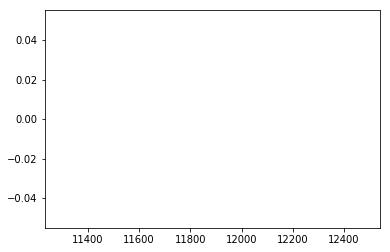